In [1]:
# Import libraries here

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

## Prepare Data

### Import

Task 1: Write a wrangle function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:

- Subset the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.
- Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".
- Create separate "lat" and "lon" columns.
- Mexico City is divided into 15 boroughs. Create a "borough" feature from the "place_with_parent_names" column.
- Drop columns that are more than 50% null values.
- Drop columns containing low- or high-cardinality categorical values.
- Drop any columns that would constitute leakage for the target "price_aprox_usd".
- Drop any columns that would create issues of multicollinearity.

In [2]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # Drop features with high null counts
    df.drop(columns=["created_on", "floor", "expenses"], inplace=True)
    
    # Drop low- and high-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

    # Drop parent columns (Columns from which others are derived from)
    df.drop(columns=["place_with_parent_names", "geonames_id", "lat-lon"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2',
    ], inplace=True)
    
    # Drop columns with multi-collinearity
    df.drop(columns=["surface_total_in_m2", "rooms", "image_thumbnail", "title", "description"], inplace=True)

    
    return df

In [3]:
# Use this cell to test your wrangle function and explore the data
df = wrangle("./properati-AR-2016-11-01-properties-rent.csv")
df.head()

,place_name,lat,lon,price_aprox_usd,surface_covered_in_m2
239,Congreso,NaN,NaN,164.42,30.0
245,Puerto Madero,-34.603185,-58.363520,920.77,70.0
258,Caballito,-34.622564,-58.434761,243.34,57.0
271,Balvanera,-34.608636,-58.403405,138.11,45.0
276,Palermo,-34.580804,-58.412091,1249.62,130.0


### Explore

The first thing we need to consider when trying to use all the features df is missing values. While it's true you can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Take a look at the output from df.info() below. Are there columns where more than half of the values are NaN? If so, those columns need to go!

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1926 entries, 239 to 43951
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   place_name             1926 non-null   object 
 1   lat                    1822 non-null   float64
 2   lon                    1822 non-null   float64
 3   price_aprox_usd        1926 non-null   float64
 4   surface_covered_in_m2  1926 non-null   float64
dtypes: float64(4), object(1)
memory usage: 90.3+ KB


Task 2: Modify your wrangle function to drop any columns that are more than half NaN values. Be sure to rerun all the cells above before you continue.

Task 3: Calculate the number of unique values for each non-numeric feature in df.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1926 entries, 239 to 43951
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   place_name             1926 non-null   object 
 1   lat                    1822 non-null   float64
 2   lon                    1822 non-null   float64
 3   price_aprox_usd        1926 non-null   float64
 4   surface_covered_in_m2  1926 non-null   float64
dtypes: float64(4), object(1)
memory usage: 90.3+ KB


Here, we can see that columns like "operation" have only one value in them, while every row in "properati_url" has a unique value. These are clear examples of high- and low-cardinality features that we shouldn't include in our model.

Task 4: Modify your wrangle function to drop high- and low-cardinality categorical features.

Be sure to rerun all the cells above before you continue.

It's also important for us to drop any columns that would constitute leakage, that is, features that were created using our target or that would give our model information that it won't have access to when it's deployed.

Task 5: Modify your wrangle function to drop any features that would constitute leakage.

Be sure to rerun all the cells above before you continue.

Finally, the last issue we need to keep an eye out for is multicollinearity, that is, features in our feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap. Let's make one!

Task 6: Plot a correlation heatmap of the remaining numerical features in df. Since "price_aprox_usd" will be your target, you don't need to include it in your heatmap.

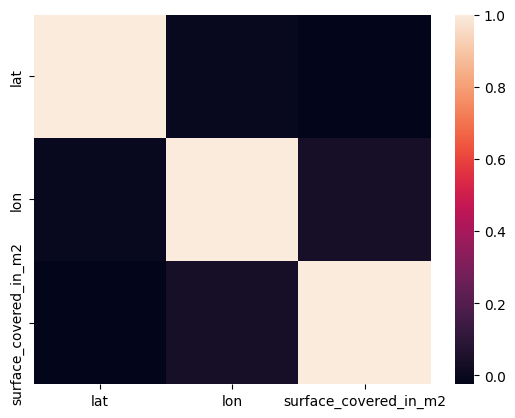

In [6]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

Task 7: Modify your wrangle function to remove columns so that there are no strongly correlated features in your feature matrix.

Be sure to rerun all the cells above before you continue.

Done! It looks like we're going to use the four features we've used in our previous models but, this time, we're going to combine them.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1926 entries, 239 to 43951
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   place_name             1926 non-null   object 
 1   lat                    1822 non-null   float64
 2   lon                    1822 non-null   float64
 3   price_aprox_usd        1926 non-null   float64
 4   surface_covered_in_m2  1926 non-null   float64
dtypes: float64(4), object(1)
memory usage: 90.3+ KB


In [8]:
df.head()

,place_name,lat,lon,price_aprox_usd,surface_covered_in_m2
239,Congreso,NaN,NaN,164.42,30.0
245,Puerto Madero,-34.603185,-58.363520,920.77,70.0
258,Caballito,-34.622564,-58.434761,243.34,57.0
271,Balvanera,-34.608636,-58.403405,138.11,45.0
276,Palermo,-34.580804,-58.412091,1249.62,130.0


### Split Data

Task 8: Create your feature matrix X_train and target vector y_train. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above.

In [9]:
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "place_name"]
X_train = df[features]
y_train = df[target]

## Build Model

### Baseline

Task 9: Calculate the baseline mean absolute error for your model.

In [10]:
y_mean = y_train.mean()
print("Mean apt price:", y_mean)
y_pred_baseline = [y_mean] * len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 920.7645275181724
Baseline MAE: 586.1063888915847


### Iterate

Task 10: Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

In [11]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['place_name'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Evaluate

Task 11: Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.

In [12]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", mae_training)

Training MAE: 353.6305428251271


Task 12: Run the code below to import your test data buenos-aires-real-estate-1.csv into a DataFrame and generate a list of predictions using your model.

In [13]:
def wrangle_test(filepath):
    df = pd.read_csv(filepath)

    # Drop rows with null values
    df.dropna(inplace=True)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["place_name"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    for col in df.columns:
        if col not in ["surface_covered_in_m2", "lat", "lon", "place_name"]:
            df.drop(columns=col, inplace=True)

    return df

X_test = wrangle_test("./buenos-aires-real-estate-1.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0     246.256198
1    1806.375168
2     542.408820
3    1231.980216
4    1147.964708
dtype: float64

## Communicate Results

We've relied on equations and visualizations for communication about our model. In many data science projects, however, communication means giving stakeholders tools they can use to deploy a model — in other words, use it in action. So let's look at two ways you might deploy this model.

One thing you might be asked to do it wrap your model in a function so that a programmer can provide inputs and then receive a prediction as output.

Task 13: Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [14]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "place_name": "place_name"
    }
    df = pd.DataFrame(data, index=[0])
    
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

Let's see if our function works. Run the cell below to find out!

In [15]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $1573.62'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. Let's create one using Jupyter Widgets.

Task 14: Add your make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.

Create an interact function in Jupyter Widgets.

In [1]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["place_name"].unique())),
);

NameError: name 'interact' is not defined

Great work! You may have noticed that there a lots of ways to improve this dashboard. For instance, a user can select a neighborhood and then supply latitude-longitude coordinates that aren't in that neighborhood. It would also be helpful to include a visualization like a map. Regardless, this is a great first step towards creating dynamic dashboards that turn your model from a complicated abstraction to a concrete tool that anyone can access. One of the most important parts of data science projects is creating products that people can use to make their work or lives easier.